# FLEAT 2017
# Quick look at UH SADCP Data

In [4]:
# %load /Users/gunnar/Projects/python/standard_imports.py
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
import os
import glob
from munch import munchify
from pathlib import Path

import pytowyo
import gvpy as gv

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Read netcdf

In [2]:
uhpath = Path('/Users/gunnar/Projects/fleat/data/gridded/RR1708/sadcp/')
uhncfiles = list(uhpath.glob('*.nc'))
print(uhncfiles[1])

/Users/gunnar/Projects/fleat/data/gridded/RR1708/sadcp/os75nb.nc


In [3]:
tmp = xr.open_dataset(uhncfiles[1])

Change from depth_cell to depth. Depth does not really change over time.

In [4]:
mdepth = tmp.depth.median(dim='time')
tmp = tmp.drop('depth')
# tmp['depth'] = (['depth_cell'], mdepth)
tmp = tmp.rename_dims({'depth_cell': 'z'})
tmp.coords['z'] = (['z'], mdepth)

Fix some attributes

In [5]:
tmp.z.attrs = dict(long_name='depth', units='m')
tmp.u.attrs = dict(long_name='u', units='m/s')
tmp.v.attrs = dict(long_name='v', units='m')
tmp.time.attrs = dict(long_name='time', units='')

In [6]:
tmp

<xarray.Dataset>
Dimensions:     (time: 5095, z: 60)
Coordinates:
  * time        (time) datetime64[ns] 2017-04-13T06:25:41.999999999 ... 2017-04-23T21:07:40
  * z           (z) float32 28.98 44.98 60.98 76.98 ... 940.98 956.98 972.98
Data variables:
    trajectory  int32 ...
    lon         (time) float64 ...
    lat         (time) float64 ...
    u           (time, z) float32 ...
    v           (time, z) float32 ...
    amp         (time, z) float32 ...
    pg          (time, z) float32 ...
    pflag       (time, z) int8 ...
    heading     (time) float32 ...
    tr_temp     (time) float32 ...
    num_pings   (time) int8 ...
    uship       (time) float32 ...
    vship       (time) float32 ...
Attributes:
    featureType:            trajectoryProfile
    history:                Created: 2017-04-23 21:08:25 UTC
    Conventions:            COARDS
    software:               pycurrents
    hg_changeset:           2344:6a53e4c1c4e4
    title:                  Shipboard ADCP velocity pro

Transpose (reorder dimensions).

In [7]:
tmp = tmp.transpose('z', 'time')

In [8]:
tmp

<xarray.Dataset>
Dimensions:     (time: 5095, z: 60)
Coordinates:
  * time        (time) datetime64[ns] 2017-04-13T06:25:41.999999999 ... 2017-04-23T21:07:40
  * z           (z) float32 28.98 44.98 60.98 76.98 ... 940.98 956.98 972.98
Data variables:
    trajectory  int32 ...
    lon         (time) float64 ...
    lat         (time) float64 ...
    u           (z, time) float32 ...
    v           (z, time) float32 ...
    amp         (z, time) float32 ...
    pg          (z, time) float32 ...
    pflag       (z, time) int8 ...
    heading     (time) float32 ...
    tr_temp     (time) float32 ...
    num_pings   (time) int8 ...
    uship       (time) float32 ...
    vship       (time) float32 ...
Attributes:
    featureType:            trajectoryProfile
    history:                Created: 2017-04-23 21:08:25 UTC
    Conventions:            COARDS
    software:               pycurrents
    hg_changeset:           2344:6a53e4c1c4e4
    title:                  Shipboard ADCP velocity pro

Make this a function for fast access in the future.

In [11]:
def read_sadcp(ncfile):
    sadcp = xr.open_dataset(ncfile)
    
    mdepth = sadcp.depth.median(dim='time')
    sadcp = sadcp.drop('depth')
    # sadcp['depth'] = (['depth_cell'], mdepth)
    sadcp = sadcp.rename_dims({'depth_cell': 'z'})
    sadcp.coords['z'] = (['z'], mdepth)
    # Fix some attributes
    sadcp.z.attrs = dict(long_name='depth', units='m')
    sadcp.u.attrs = dict(long_name='u', units='m/s')
    sadcp.v.attrs = dict(long_name='v', units='m')
    sadcp.time.attrs = dict(long_name='time', units='')
    # Transpose (re-order dimensions)
    sadcp = sadcp.transpose('z', 'time')    
    
    return sadcp

In [12]:
test = read_sadcp(uhncfiles[0])

ok, now also included in gvpy

In [13]:
tmp = gv.io.read_sadcp(uhncfiles[1])

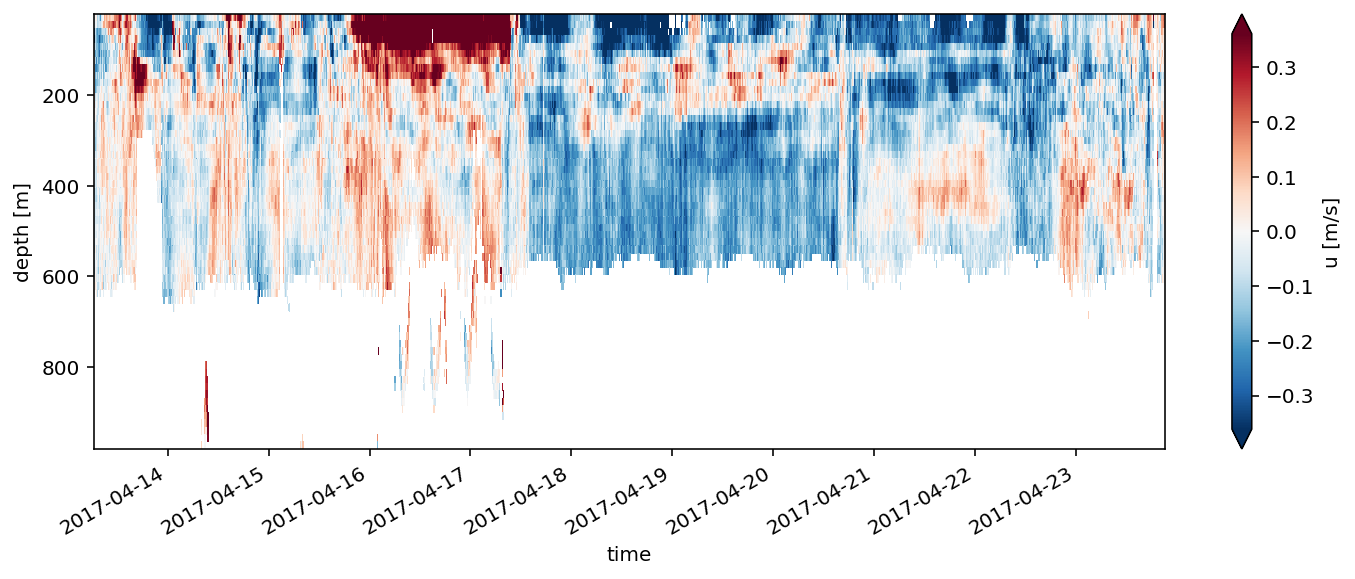

In [14]:
tmp.u.plot(x='time', figsize=(12,4), yincrease=False, robust=True)

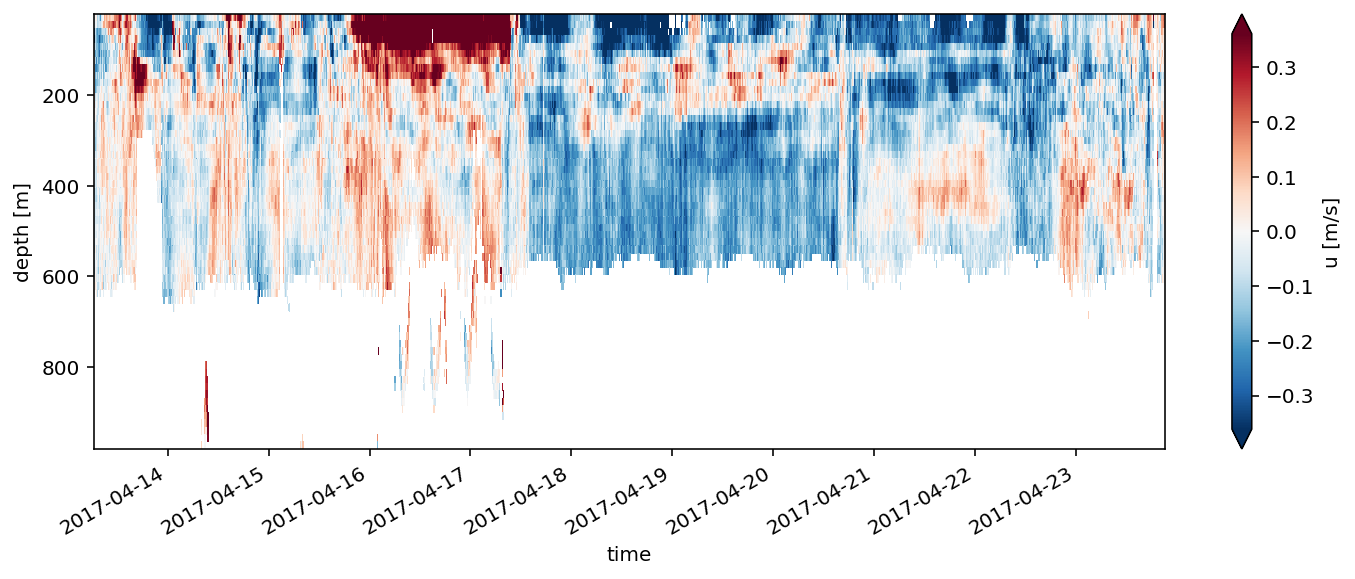

In [15]:
tmp.u.where(tmp.pflag==0).plot(x='time', figsize=(12,4), yincrease=False, robust=True)

## Read .mat

I'm not quite sure of the best way to work with the UH data. The .mat files generated load_getmat have a nanmask - is the result similar to what we get from the netcdf file?

In [8]:
uhmatfiles = sorted(list(uhpath.glob('*.mat')))
print(uhmatfiles[1])

/Users/gunnar/Projects/fleat/data/gridded/RR1708/sadcp/rr1708_sadcp_75khz.mat


In [9]:
def uhmat_to_uhDataset(uhfile):
    tmp = gv.gvimport.gvloadmat(uhfile, onevar=True)
    tmp.time = gv.gvimport.mtlb2datetime(tmp.dtnum)
    
    uh = xr.Dataset(data_vars={'u': (['z', 'time'], tmp.u),
                               'v': (['z', 'time'], tmp.v),
                               'w': (['z', 'time'], tmp.w),
                               'nanmask': (['z', 'time'], tmp.nanmask)
                               },
                coords={'time': (['time'], tmp.time),
                        'lon': (['time'], tmp.lon),
                        'lat': (['time'], tmp.lat),
                        'z': (['z'], tmp.z)
                        })
    return uh

In [10]:
uh = {}
uh['75k'] = uhmat_to_uhDataset(uhmatfiles[1])
uh['150k'] = uhmat_to_uhDataset(uhmatfiles[0])

returning munchified data structure
returning munchified data structure


## Compare

In [11]:
tmp2 = uh['75k']

In [30]:
time_interval = slice('2017-04-18', '2017-04-19')

Plot .mat-file with nanmask applied.

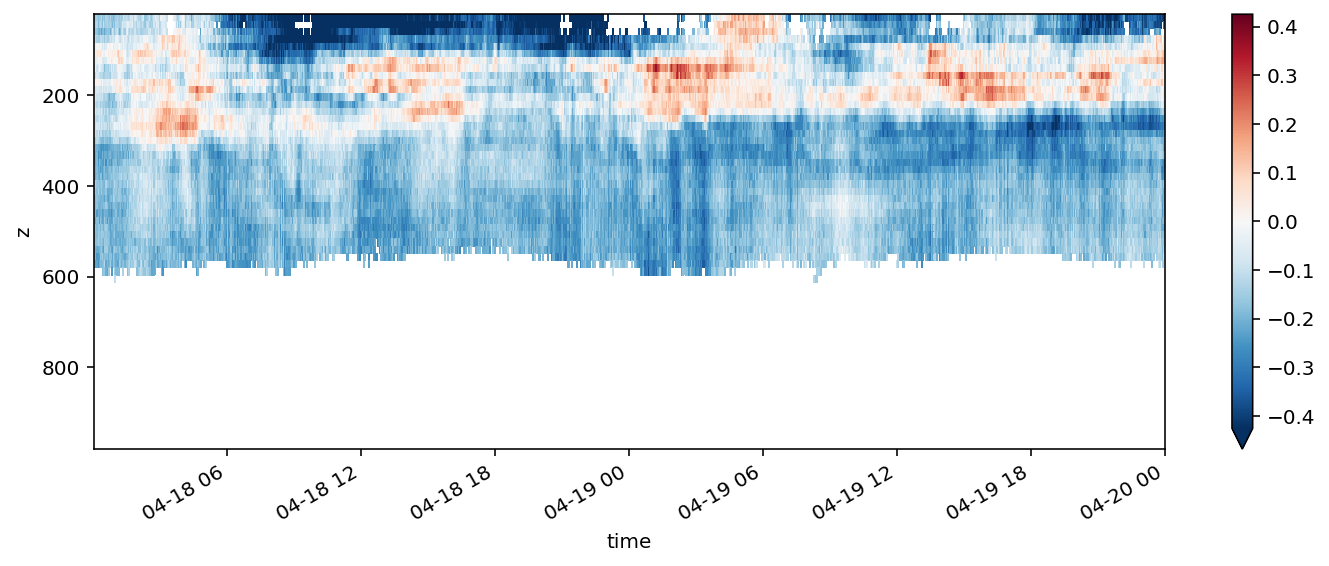

In [31]:
(tmp2.u * tmp2.nanmask).sel(time=time_interval).plot(x='time', figsize=(12,4), yincrease=False, robust=True)

Plot netcdf file with pflag applied.

From UHDAS website https://currents.soest.hawaii.edu/docs/adcp_doc/ADCP_INTERPRETATION/adcp_access/READING/NetCDF/index.html?highlight=pflag
```
Profile flags
-------------
Profile editing flags are provided for each depth cell:

binary    decimal    below    Percent
value     value      bottom   Good       bin
-------+----------+--------+----------+-------+
000         0
001         1                            bad
010         2                  bad
011         3                  bad       bad
100         4         bad
101         5         bad                bad
110         6         bad      bad
111         7         bad      bad       bad
-------+----------+--------+----------+-------+
```

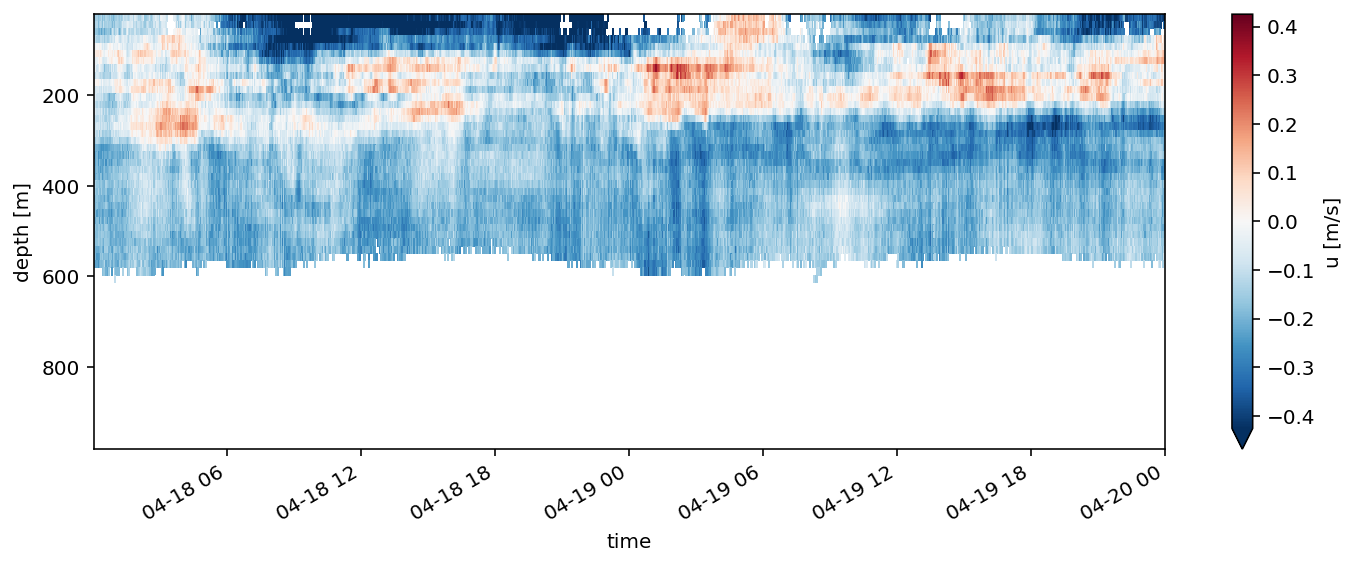

In [32]:
tmp.u.where(tmp.pflag==0).sel(time=time_interval).plot(x='time', figsize=(12,4), yincrease=False, robust=True)

Plot netcdf file.

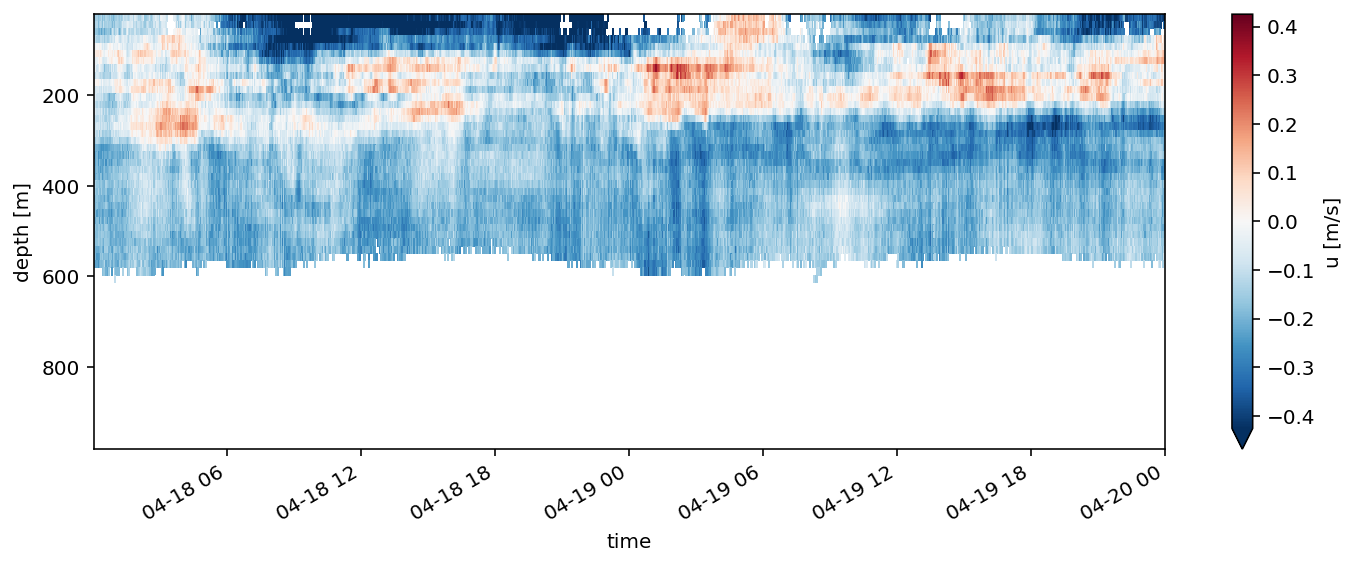

In [33]:
tmp.u.sel(time=time_interval).plot(x='time', figsize=(12,4), yincrease=False, robust=True)

They all look the same to me...